In [3]:
from importlib import reload
import sys
sys.path += ["/home/jacopo.lenti/Projects/learning-od-step-by-step/src"]
import opinion_dynamics_models_estimation as oe
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
from tqdm import tqdm
import numpy as np

In [4]:
reload(oe)

<module 'repeat_function' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/repeat_function.py'>

In [12]:
def rep_simulations(fn, single_vars, list_vars, repetitions = 1, verbose = False, print_every = 1):
    #input 
    #single_vars = {"b": b1, "c": c1}
    #list_vars = {"a": [a1,a2], "d": [d1,d2]}
    #fn = fn(a,b,c,d)
    #repetitions
    #
    #repeat fn for each possible vector (a1,b1,c1,d1), (a2,b1,c1,d1), (a1,b1,c1,d2), (a2,b1,c1,d2)
    
    
    outputs = []
    i = 0
    tot_sim = len(list(product(*list(list_vars.values())))) * repetitions
    
    for rep in range(repetitions):
        for lists_vars_element in [dict(zip(list_vars.keys(), items)) for items in product(*list(list_vars.values()))]:
            
            input_vector = single_vars|lists_vars_element
            outputs.append([lists_vars_element, fn(**input_vector)])
              
            i += 1
            if verbose:
                if i % print_every == 0:
                    print(f"Simulation {i} of {tot_sim}")
                  
              
        
    return outputs
 

In [13]:
def nested_rep(input_fn1, output_fn1_names, input_fn2, verbose = True):
    outputs = []
    
    
    for out1 in tqdm(rep_simulations(*input_fn1), disable = not verbose):
        
        fn2, single_vars2, list_vars2, repetitions2 = input_fn2
        temp_single_vars2 = {**single_vars2, **dict(zip(output_fn1_names, out1[1]))}
        for out2 in rep_simulations(fn2, temp_single_vars2, list_vars2, repetitions2):
            outputs.append({**input_fn1[1], **out1[0], **out2[0], **out2[1]})
    return outputs

In [14]:
N,T,edge_per_t = 200, 300, 8

model_name = "simple_BC"

evidences_per_t = 16

optimizer_name = "RMSprop"

lr, num_epochs = 0.1, 200   
epsilon0 = 0.05
epsilon, mu, rho = parameters = 0.32, 0.23, 70
hide_progress = False

patience, min_delta, min_epochs, sample_pairs = 20, 1e-6, 20, 50

In [15]:
X, edges, evidences = oe.simulate_BC(N, T, edge_per_t, 10, (epsilon, mu, rho))

In [221]:
history = oe.estimation_BC_model_from_data(X, edges, evidences, parameters,
                                           epsilon0, "BC_with_evidence",optimizer_name,
                                           lr, num_epochs, hide_progress, patience, min_delta,
                                           min_epochs, sample_pairs, summarized = False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:37<00:00,  2.06it/s]


In [222]:
history["epsilon"][-10:]

[0.3443546980432358,
 0.3221564285715202,
 0.34441860495447574,
 0.3218310028538424,
 0.3443243929204808,
 0.3222835764752614,
 0.3444305296100567,
 0.32174689512498766,
 0.3442965392634441,
 0.32237006760985665]

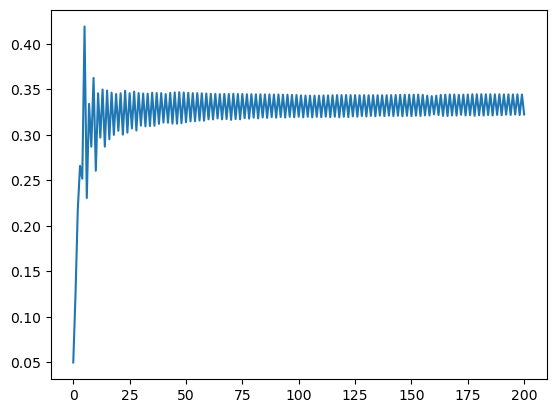

In [224]:
plt.plot(history["epsilon"])

In [198]:
history["epsilon"][-1]

0.024152370081616005

In [72]:
repetitions = 4

In [75]:
nested_simulations = []


for _ in range(repetitions):
    epsilon, mu = np.random.random(2) / 2
    rho = np.random.choice([3,15,70])
    
    
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N": 100, "parameters": [epsilon, mu, rho]}, 
                                                      {"T": [20, 40, 80], "edge_per_t": [4,16, 64], "evidences_per_t": [5,25]},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [oe.estimation_BC_model_from_data, 
                                                      {"epsilon0": 0.25, "num_epochs": 200, 
                                                       "hide_progress": hide_progress, "patience": patience, "min_delta":min_delta,
                                                       "min_epochs":min_epochs, "sample_pairs":50,"parameters": [epsilon, mu, rho], 
                                                       "summarized": True}, 
                                                      {"optimizer_name": ["adam", "RMSprop", "adagrad", "nadam"], 
                                                       "lr": [0.0001, 0.0005, 0.001, 0.005, 0.01], "model_name": ["simple_BC", "BC_with_evidence", "BC_observed_positive"]}, 
                                 1
                                ]
                               )


100%|████████████████████████████████████████████████████████████████| 18/18 [33:06<00:00, 110.37s/it]


In [76]:
simulations_df = pd.DataFrame(nested_simulations)\
.assign(real_epsilon = lambda x: [u[0] for u in x["parameters"]],
        mu = lambda x: [u[1] for u in x["parameters"]],
        rho = lambda x: [u[2] for u in x["parameters"]]
       )\
.drop("parameters", axis = 1)\
.assign(distance_epsilon = lambda x: np.abs(x["real_epsilon"]-  x["epsilon_estimated"]))

In [77]:
#simulations_df.to_csv("/home/jacopo.lenti/Projects/learning-od-step-by-step/data/nested_simulations_230712.csv", index = None)

In [71]:
#pd.read_csv("/home/jacopo.lenti/Projects/learning-od-step-by-step/data/nested_simulations_230712.csv")

In [225]:
simulations_df

,N,T,edge_per_t,evidences_per_t,optimizer_name,lr,model_name,epsilon_estimated,time,num_epochs,X0_mse,real_epsilon,mu,rho,distance_epsilon
0,100,20,4,5,adam,0.0001,simple_BC,0.253728,0.083652,201,NaN,0.333674,0.490379,15,0.079946
1,100,20,4,5,adam,0.0001,BC_with_evidence,0.246296,7.777270,201,0.156825,0.333674,0.490379,15,0.087378
2,100,20,4,5,adam,0.0001,BC_observed_positive,0.253736,0.538081,201,NaN,0.333674,0.490379,15,0.079938
3,100,20,4,5,adam,0.0005,simple_BC,0.268047,0.071118,201,NaN,0.333674,0.490379,15,0.065628
4,100,20,4,5,adam,0.0005,BC_with_evidence,0.230758,7.926068,201,0.159534,0.333674,0.490379,15,0.102916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,100,80,64,25,nadam,0.0050,BC_with_evidence,0.183468,7.771357,201,0.156559,0.353722,0.383031,70,0.170253
4316,100,80,64,25,nadam,0.0050,BC_observed_positive,0.342616,1.750326,201,NaN,0.353722,0.383031,70,0.011106
4317,100,80,64,25,nadam,0.0100,simple_BC,0.353066,0.084868,194,NaN,0.353722,0.383031,70,0.000655
4318,100,80,64,25,nadam,0.0100,BC_with_evidence,0.181922,7.768863,201,0.092931,0.353722,0.383031,70,0.171799


<AxesSubplot:xlabel='optimizer_name', ylabel='lr'>

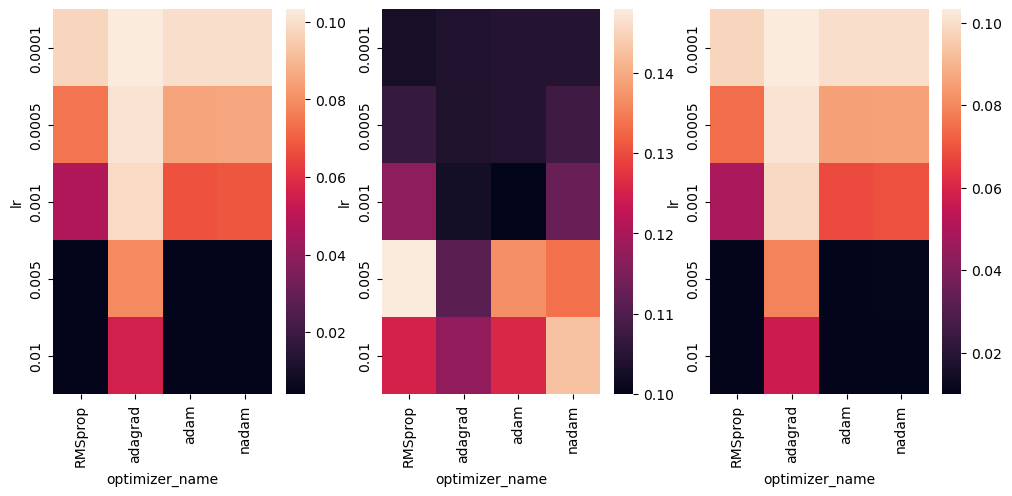

In [234]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12,5))

sns.heatmap(data = simulations_df.query("(model_name == 'simple_BC')&(rho == 70)").groupby(["lr", "optimizer_name"]).mean()["distance_epsilon"].unstack(), ax = axes[0], )
sns.heatmap(data = simulations_df.query("(model_name == 'BC_with_evidence')&(rho == 70)").groupby(["lr", "optimizer_name"]).mean()["distance_epsilon"].unstack(), ax = axes[1])
sns.heatmap(data = simulations_df.query("(model_name == 'BC_observed_positive')&(rho == 70)").groupby(["lr", "optimizer_name"]).mean()["distance_epsilon"].unstack(), ax = axes[2])



In [227]:
simulations_df.groupby("model_name").mean()["time"] #.query("(optimizer_name == 'adam') & (lr == 0.005) & (model_name == 'BC_with_evidence')").sort_values("distance_epsilon")


model_name
BC_observed_positive     1.187993
BC_with_evidence        13.577166
simple_BC                0.077549
Name: time, dtype: float64

<AxesSubplot:xlabel='real_epsilon', ylabel='epsilon_estimated'>

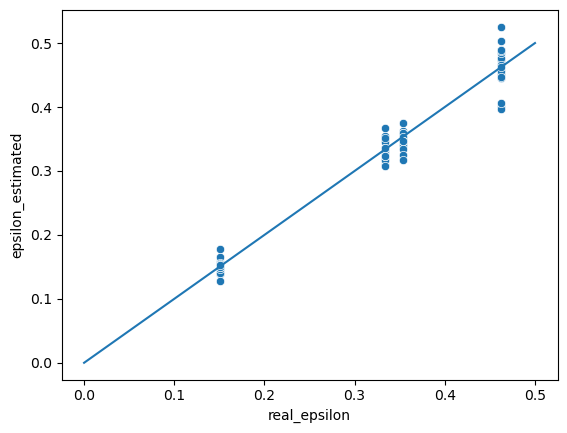

In [188]:
sns.scatterplot(data = simulations_df.query("(lr == 0.01)&(optimizer_name == 'RMSprop') & (model_name == 'BC_observed_positive')"), 
                x = "real_epsilon", y = "epsilon_estimated")
sns.lineplot(x = np.array([0,0.5]), y = np.array([0,0.5]))

In [109]:
simulations_df.groupby("model_name").sum()["time"]

model_name
BC_observed_positive     1710.709256
BC_with_evidence        19551.118431
simple_BC                 111.670539
Name: time, dtype: float64